In [1]:
#Proyecto: Clasificación de galaxias mediante imágenes (clasificación multietiqueta)
#Objetivo: Desarrollar un modelo de aprendizaje automático capaz de clasificar galaxias en múltiples categorías basándose en imágenes astronómicas.

#Importar paquetes necesarios
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchmetrics import PearsonCorrCoef
from sklearn.preprocessing import StandardScaler

#Configuraciones generales
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
DATA_DIR = '.\Datasets'

print(f'DEVICE: {DEVICE}')
IMG_TRAIN_DIR = os.path.join(DATA_DIR, 'images_training_rev1')
IMG_TEST_DIR = os.path.join(DATA_DIR, 'images_test_rev1')
LABELS_CSV = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
SUBMISSION_CSV = os.path.join(DATA_DIR, 'all_zeros_benchmark.csv')

c:\Users\diego\miniconda3\envs\astro_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda


In [2]:
#Preprocesamientos

labels_df = pd.read_csv(LABELS_CSV) #Lectura del archivo CSV de etiquetas
print(f'Labels DataFrame shape: {labels_df.shape}')
print(f'First 8 columns: {labels_df.columns[:8].to_list()}')

bench = pd.read_csv(SUBMISSION_CSV) #Lectura del archivo CSV de benchmark
#Usar el orden de las filas del benchmark para el conjunto de prueba y estar seguros de que las predicciones se alinean correctamente
target_cols = bench.columns[1:].to_list()
print(f'Benchmark DataFrame shape: {bench.shape}')
print(f'Target columns: {target_cols}')

#Asegurarse de que las columnas de etiquetas coincidan con las del benchmark y estén en el mismo orden
missing_taget_cols = [col for col in target_cols if col not in labels_df.columns]
assert len(missing_taget_cols) == 0, f'Missing target columns in labels_df: {missing_taget_cols}'


Labels DataFrame shape: (61578, 38)
First 8 columns: ['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2']
Benchmark DataFrame shape: (79975, 38)
Target columns: ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']


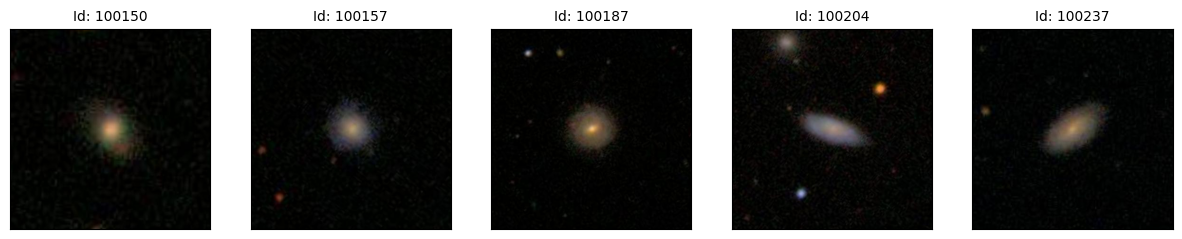

In [3]:
#Visualización de imágenes

def show_image(dir, num_images=5, ids=None):
    fig = plt.figure(figsize=(15, 5))
    for j in range(10, 10 + num_images):
        img_path = os.path.join(dir, str(ids[j]) + '.jpg')
        img = imread(img_path) 
        ax = fig.add_subplot(1, num_images, j - 10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f'Id: {ids[j]}', fontsize=10)  
    plt.show()

labels_id = labels_df['GalaxyID'].tolist()
show_image(IMG_TRAIN_DIR, num_images=5, ids=labels_id)

In [4]:
#Definir los transformadores de datos

#Redimensionar todas las imágenes a un tamaño fijo (ahora mismo son de 424x424)
SIZE = 224

transform_train = transforms.Compose([
    transforms.Resize([SIZE, SIZE]),
    transforms.RandomCrop(SIZE, padding=4), #recorte aleatorio con relleno (a veces con relleno a veces no)
    transforms.RandomHorizontalFlip(), #volteo horizontal aleatorio
    transforms.RandomRotation(15),  #rotación aleatoria 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize([SIZE, SIZE]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


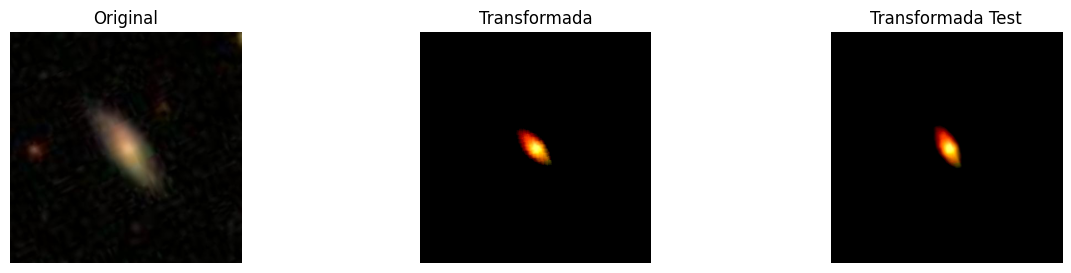

Original image shape: (424, 424)
Transformed image shape (train): (224, 224, 3)
Transformed image shape (test): (224, 224, 3)


In [5]:
#Comprobar los transformadores de datos en imágenes y mostrar una imagen transformada

img_id = labels_id[1]
img_path = os.path.join(IMG_TRAIN_DIR, str(img_id) + '.jpg')
img = Image.open(img_path)

fig = plt.figure(figsize=(15, 3))

# Original
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax.set_title("Original")
ax.axis("off")

# Transformada con train transform
img_transformed = transform_train(img)   
img_transformed = img_transformed.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_transformed)
ax.set_title("Transformada")
ax.axis("off")

#Transformada con test transform
img_transformed_test = transform_test(img)  
img_transformed_test = img_transformed_test.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_transformed_test)
ax.set_title("Transformada Test")
ax.axis("off")

plt.show()

print(f'Original image shape: {img.size}')
print(f'Transformed image shape (train): {img_transformed.shape}')
print(f'Transformed image shape (test): {img_transformed_test.shape}')

In [6]:
#Crear el dataset personalizado y cargar en el DataLoader

#Dado que no se dispone de las etiquetas del test nos enfocaremos en el dataset de entrenamiento y validación
class GalaxyDataset(Dataset):
    def __init__(self, images_dir, labels_id,  labels, transform=None):
        self.images_dir = images_dir
        self.labels_id = labels_id
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels[self.labels.columns[0]])
    
    def __getitem__(self, idx):
        img_id = self.labels_id[idx]
        img_path = os.path.join(self.images_dir, str(img_id) + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, label

labels_id = labels_df['GalaxyID'].tolist()
target_cols = bench.columns[1:].to_list()

max_train_size = len(labels_df) - (len(labels_df) // 5) #80% para entrenamiento, 20% para validación
galaxy_train_labels_id = Subset(labels_id, list(range(0, max_train_size))) #muestras para entrenamiento
galaxy_val_labels_id = Subset(labels_id, list(range(max_train_size, len(labels_df)))) #resto para validación

scaler_y = StandardScaler() #Inicializar un scaler para las labels

# train_labels_raw_scaled = scaler_y.fit_transform(labels_df.iloc[galaxy_train_labels_id.indices][target_cols])
# val_labels_raw_scaled = scaler_y.fit_transform(labels_df.iloc[galaxy_val_labels_id.indices][target_cols])

# galaxy_train_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_train_labels_id, pd.DataFrame(train_labels_raw_scaled, columns=target_cols), transform=transform_train)
# galaxy_val_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_val_labels_id, pd.DataFrame(val_labels_raw_scaled, columns=target_cols), transform=transform_test)

train_labels_raw_scaled = (labels_df.iloc[galaxy_train_labels_id.indices][target_cols])
val_labels_raw_scaled = (labels_df.iloc[galaxy_val_labels_id.indices][target_cols])

galaxy_train_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_train_labels_id, train_labels_raw_scaled, transform=transform_train)
galaxy_val_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_val_labels_id, val_labels_raw_scaled, transform=transform_test)

num_cores = os.cpu_count()
#Crear los DataLoaders
galaxy_train_dl = DataLoader(galaxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
galaxy_val_dl = DataLoader(galaxy_val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print('Num cores / 2: ', num_cores//2)
print(f'Number of training samples: {len(galaxy_train_dataset)}')
print(f'Number of validation samples: {len(galaxy_val_dataset)}')



Num cores / 2:  8
Number of training samples: 49263
Number of validation samples: 12315


In [7]:
#Creacion de un modelo de red neuronal convolucional (CNN) usando la GPU

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=len(target_cols)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) #3 canales de entrada (RGB), 32 filtros (detectar patrones locales borde)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) #Reducción de dimensionalidad y extracción de características

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AvgPool2d(2, 2)

        alto_ancho_final = SIZE // 16  #Reducción de tamaño tras 4 capas de pooling
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * alto_ancho_final * alto_ancho_final, 512) # fc1: salida adaptada a 256 canales  
        self.out = nn.Linear(512, num_classes)
        self.relu = nn.ReLU() #ReLU: introduce no linealidad, permite aprender patrones complejos
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #Reducción de dimensionalidad y extracción de características
        self.dropout = nn.Dropout(0.3) #Dropout: técnica de regularización para prevenir sobreajuste

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.Flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.out(x)
        return x

model = GalaxyCNN().to(DEVICE)
print(model)

GalaxyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Fla

In [8]:
import time
start = time.time()
x_batch, y_batch = next(iter(galaxy_train_dl))
end = time.time()
print(f'Tiempo para cargar un batch: {end-start:.2f}s')

#Conprobar la salida del modelo y dimensiones
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
start = time.time()
outputs = model(x_batch)
end = time.time()
print(f'Tiempo para pasar un batch por el modelo: {end-start:.2f}s')
print(f'Input batch shape: {x_batch.shape}')
print(f'Output batch shape: {outputs.shape}')


Tiempo para cargar un batch: 0.20s
Tiempo para pasar un batch por el modelo: 0.64s
Input batch shape: torch.Size([32, 3, 224, 224])
Output batch shape: torch.Size([32, 37])


In [9]:
# Función de pérdida: BCEWithLogitsLoss para clasificación multietiqueta
loss_fn = nn.BCEWithLogitsLoss()

# Optimizador: Adam con tasa de aprendizaje de 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
def train_val_model(num_epochs, model, dl_train, dl_val, loss_fn, optimizer, device=DEVICE):
    train_loss, val_loss = [], []
    train_corr_list, val_corr_list = [], []

    #Definir métricas
    train_corr_metric = PearsonCorrCoef(num_outputs=37).to(device) #Calcualr los valores de esta forma mejor que a mano, más preciso
    val_corr_metric = PearsonCorrCoef(num_outputs=37).to(device)

    for epoch in range(num_epochs):
    
        model.train()
        loss_hist = 0
        train_corr_metric.reset()
        
        for x_batch, y_batch in dl_train:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

            loss_hist += loss.item() * y_batch.size(0)

            #Actualizar métrica
            train_corr_metric.update(torch.sigmoid(pred), y_batch)

        epoch_loss = loss_hist / len(dl_train.dataset)
        epoch_corr = train_corr_metric.compute().mean().item()  # promedio sobre todas las clases
        train_loss.append(epoch_loss)
        train_corr_list.append(epoch_corr)


        model.eval()
        loss_hist = 0
        val_corr_metric.reset()
        with torch.no_grad():
            for x_batch, y_batch in dl_val:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist += loss.item() * y_batch.size(0)
                val_corr_metric.update(torch.sigmoid(pred), y_batch)

        epoch_loss_val = loss_hist / len(dl_val.dataset)
        epoch_corr_val = val_corr_metric.compute().mean().item()
        val_loss.append(epoch_loss_val)
        val_corr_list.append(epoch_corr_val)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train CORR: {epoch_corr:.4f}, '
              f'Val Loss: {epoch_loss_val:.4f}, Val CORR: {epoch_corr_val:.4f}')

    return train_loss, train_corr_list, val_loss, val_corr_list

#Entrenamiento
tr_loss, tr_corr, val_loss, val_corr = train_val_model(NUM_EPOCHS, model, galaxy_train_dl, galaxy_val_dl, loss_fn, optimizer, DEVICE)


Epoch 1/25, Train Loss: 0.2855, Train CORR: 0.3196, Val Loss: 0.2654, Val CORR: 0.4825
Epoch 2/25, Train Loss: 0.2663, Train CORR: 0.4471, Val Loss: 0.2671, Val CORR: 0.5082
Epoch 3/25, Train Loss: 0.2590, Train CORR: 0.5072, Val Loss: 0.2496, Val CORR: 0.5975
Epoch 4/25, Train Loss: 0.2546, Train CORR: 0.5437, Val Loss: 0.2488, Val CORR: 0.6071
Epoch 5/25, Train Loss: 0.2515, Train CORR: 0.5717, Val Loss: 0.2451, Val CORR: 0.6283


KeyboardInterrupt: 

In [ ]:
#Graficar las curvas de pérdida y precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_corr, label='Train Acc', color='blue')
plt.plot(val_corr, label='Val Acc', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#Mostrar predicciones
def show_pred(dataloader, model, device, num_examples=5):
    model.eval()

    for _ in range(num_examples):
        x_batch, y_batch = next(iter(dataloader))
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            pred_labels = (pred > 0.5).float()
        
        plt.imshow(np.transpose(x_batch.numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.title(f"True: {y_batch.numpy()}\nPred: {pred_labels}")
        plt.show()


In [ ]:
#Genear un df con los resultados tras aplicar el modelo a un dataset

#1. Genarar un Dayaset con todos los datos sin dividir
galaxy_dataset = GalaxyDataset(IMG_TRAIN_DIR, labels_id, labels_df.iloc[labels_id.indices][target_cols])
#2. Genar un Dataloader sin hacer suffle
galaxy_dataloader = DataLoader(galaxy_dataset, batch_size=BATCH_SIZE, pin_memory=True)
#3. Genear df
def generar_df(dataloader, model, device):
    model.eval()

    with torch.no_grad():  # CORRECCIÓN: paréntesis en no_grad()
        all_preds = []
        
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.append(pred.cpu())
        all_preds = all_preds.cat(all_preds, dim=0).numpy()
        
        # Crear DataFrame con predicciones y etiquetas
        df_preds = pd.DataFrame(all_preds, columns=[labels_df.columns.to_list()])
        df_labels = pd.DataFrame(labels_id, columns=['GalaxyID'])

        df_final = pd.concat([df_labels, df_preds], axis=1)

    return df_final

df_final = generar_df(galaxy_dataloader, model, DEVICE)

df_final.head()